# My First Neural Network


In this course, we will build our first neural network using the [micrograd](https://github.com/karpathy/micrograd/tree/master) library. Micrograd is a simple and easy-to-understand library specialized in automatic gradient calculation. To master it better, you can watch the [introduction video](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4s&ab_channel=AndrejKarpathy) by Andrej Karpathy (in English).
This notebook is also inspired by the notebook provided in the micrograd repository.


## Building a Neural Network with micrograd


In [1]:
#!pip install micrograd # uncomment to install micrograd
import random
import numpy as np 
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

To build a neural network, we first need a problem to solve. We use the [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function from scikit-learn, which generates a dataset.
To simplify the loss calculation in the following steps, we replace the classes 0 and 1 with -1 and 1.


### Dataset Initialization


Les données d'entrée sont de la forme :  [-0.81882941  0.05879006]


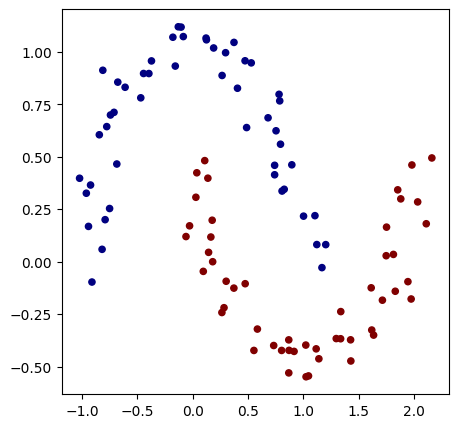

In [2]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) # 100 éléments et un bruit Gaussien d'écart type 0.1 ajouté sur les données 

print("Les données d'entrée sont de la forme : ",X[1])

y = y*2 - 1 # Pour avoir y=-1 ou y=1 (au lieu de 0 et 1)

# Visualisation des données en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Creating the Neural Network


Now, we will initialize our neural network. It takes 2 values as input and must produce a label of -1 or 1.
The network we will build has 2 hidden layers, each containing 16 neurons. Each neuron acts as a logistic regression, making our network a non-linear combination of multiple logistic regressions.
Here is an overview of the architecture of this network:
![Mlp](./images/Mlp.png)


In [3]:
# Initialisation du modèle 
model = MLP(2, [16, 16, 1]) # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Nombre de paramètres 337


### Stochastic Gradient Descent (SGD)


Before continuing, let's review stochastic gradient descent (SGD).
To apply the gradient descent algorithm on a dataset of size $N$, in theory, you would need to calculate the loss and gradient for each element before updating the weights. This method ensures a decrease in loss at each iteration, but it is very costly for datasets where $N$ is large (often $N>10⁶$). Additionally, you would need to store the gradients of all $N$ elements in memory, which is impossible for large datasets.
To solve this problem, we use *mini-batches*, which are groups of samples from the dataset. Optimization is done as in classical gradient descent, but the weights are updated at each *mini-batch* (thus more frequently). This makes the optimization process faster and allows handling large amounts of data. The size of a *mini-batch* is called *batch size* and is often 16, 32, or 64.
To learn more about stochastic gradient descent, check [Wikipedia](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique) or this [blogpost](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31).
Let's define a Python function to retrieve *batch_size* random elements from our dataset.


In [4]:
def get_batch(batch_size=64):
  ri = np.random.permutation(X.shape[0])[:batch_size]
  Xb, labels = X[ri], y[ri]
  #inputs = [list(map(Value, xrow)) for xrow in Xb] # OLD
  # Conversion des inputs en Value pour pouvoir utiliser micrograd
  inputs = [list([Value(xrow[0]),Value(xrow[1])]) for xrow in Xb]
  return inputs,labels

### Loss Function


To train our neural network, we need to define a loss function. In our case, we have two classes and we want to maximize the margin between examples belonging to different classes. Unlike the negative log-likelihood loss used previously, we aim to maximize this margin, making our method more robust to new elements.
We use the *max-margin loss*, defined by:
$\text{loss} = \max(0, 1 - y_i \cdot \text{score}_i)$


In [5]:
def loss_function(scores,labels):
  # La fonction .relu() prend le maximum entre 0 et la valeur de 1 - yi*scorei
  losses = [(1 - yi*scorei).relu() for yi, scorei in zip(labels, scores)]
  # On divise le loss par le nombre d'éléments du mini-batch
  data_loss = sum(losses) * (1.0 / len(losses))
  return data_loss

### Model Training


Now that we have the key elements for training, it's time to define our training loop


In [6]:
# Définissons nos hyper-paramètres d'entraînement 
batch_size=128
iteration=50

We can now start training our model:


In [7]:
for k in range(iteration):
    
  # On récupère notre mini-batch random
  inputs,labels=get_batch(batch_size=batch_size)

  # On fait appel au modèle pour calculer les scores Y
  scores = list(map(model, inputs))
  
  # On calcule le loss
  loss=loss_function(scores,labels)


  accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
  accuracy=sum(accuracy) / len(accuracy)
  
  # Remise à zéro de valeurs de gradients avant de les calculer
  model.zero_grad() 
  # Calcul des gradients grâce à l'autograd de micrograd
  loss.backward() 
  
  # Mise à jour des poids avec les gradients calculés (SGD)
  learning_rate = 1.0 - 0.9*k/100 # On diminue le learning rate au fur et à mesure de l'entraînement
  for p in model.parameters():
      p.data -= learning_rate * p.grad
  
  if k % 1 == 0:
      print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.8862514464368221, accuracy 50.0%
step 1 loss 1.7136790633950052, accuracy 81.0%
step 2 loss 0.733396126728699, accuracy 77.0%
step 3 loss 0.7615247055858604, accuracy 82.0%
step 4 loss 0.35978083334534205, accuracy 84.0%
step 5 loss 0.3039360355411295, accuracy 86.0%
step 6 loss 0.2716587340549048, accuracy 89.0%
step 7 loss 0.25896576803013205, accuracy 91.0%
step 8 loss 0.2468445503533517, accuracy 91.0%
step 9 loss 0.26038987927745966, accuracy 91.0%
step 10 loss 0.23569710047306525, accuracy 91.0%
step 11 loss 0.2403768930229477, accuracy 92.0%
step 12 loss 0.20603128479123115, accuracy 91.0%
step 13 loss 0.22061157796029193, accuracy 93.0%
step 14 loss 0.19010711228374735, accuracy 92.0%
step 15 loss 0.21687609382796402, accuracy 93.0%
step 16 loss 0.18642445342175254, accuracy 92.0%
step 17 loss 0.2064478196088666, accuracy 92.0%
step 18 loss 0.15299793102189654, accuracy 94.0%
step 19 loss 0.18164592701596197, accuracy 93.0%
step 20 loss 0.15209012673698674, accura

As you can see, the *loss* does not consistently decrease at each training step. This is due to stochastic gradient descent: not considering the entire dataset at each iteration introduces randomness. However, the *loss* decreases on average during training, allowing us to obtain a robust model more quickly.


(-1.548639298268643, 1.951360701731357)

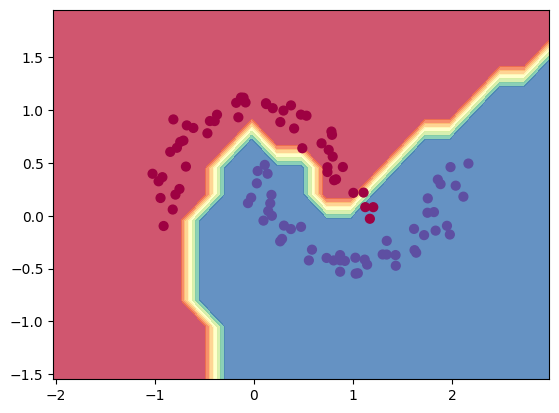

In [8]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())